In [1]:
import os
from os.path import isdir, exists, join
import nibabel as nib
from matplotlib import pyplot as plt
import torchio as tio
from multiprocessing import Pool


/labs/gevaertlab/users/thomas/miniconda/envs/multimodal/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create Brain masks

In [ ]:
DATA_DIR = "../data/MR/REMBRANDT"
cases = [f for f in os.listdir(DATA_DIR) if isdir(join(DATA_DIR, f))]

def create_mask(case):
    if not exists(join(DATA_DIR, case, "brain_mask.nii.gz")):
        print(f"\nProcessing {case}")
        t1_path = [join(DATA_DIR, case,f) for f in os.listdir(join(DATA_DIR, case)) if "t1" in f.lower()][0]
        img = nib.load(t1_path)
        brain_mask = (img.get_fdata() > 1)
        brain_mask = brain_mask.astype(float)
        final_brain_mask = nib.Nifti1Image(brain_mask, img.affine)  
        nib.save(final_brain_mask, join(DATA_DIR, case, "brain_mask.nii.gz"))
    else:
        print(f"\n{case} Already masked.")


pool = Pool(20)
pool.map(create_mask,cases)

# Viewer

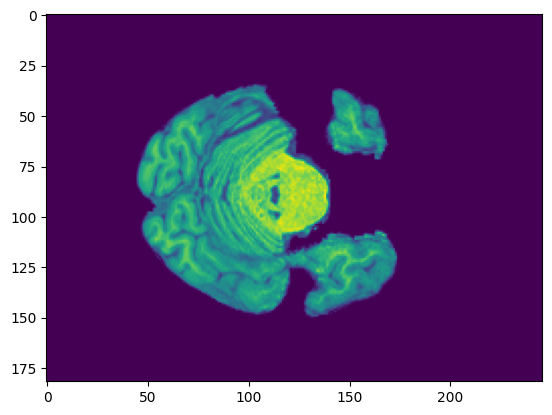

In [30]:
img = nib.load("../data/MR/UKBIOBANK/1799943/1799943_T1.nii.gz").get_fdata()
plt.imshow(img[:,:,60])

# Create binned survival TCGA

In [2]:
import pandas as pd
n=4
df = pd.read_csv("../data/metadata/TCGA_metadata.csv", index_col="case")
df['survival_bin'] = pd.qcut(df['survival_months'], n, labels = [x for x in range(n)])
df['survival_bin'].value_counts()

df.to_csv("../data/metadata/TCGA_metadata.csv", index=True)


# Update UKB database

In [2]:
from os.path import join
import shutil

actual = set(ls_dir("/home/tbarba/projects/MultiModalBrainSurvival/data/MR/UKBIOBANK"))
complete = set(pd.read_csv("/home/tbarba/projects/MultiModalBrainSurvival/complete.csv")["eid"].astype(str))

ROOT = "/home/tbarba/projects/MultiModalBrainSurvival/data/MR"

for f in ls_dir(ROOT + "/UKBIOBANK"):
    if f not in complete:
        # shutil.move(join(ROOT, "UKBIOBANK", f), join(ROOT, "UKB_incomplete", f))


IndentationError: expected an indented block (3010418809.py, line 11)

# Move from temp location

In [59]:
FROM = "/home/tbarba/storage/uk_biobank_2020/update/data/run41271/downloaded"

for case in ls_dir(FROM):
    shutil.move(FROM+"/"+case, ROOT+"/UKBIOBANK/"+case)

len(ls_dir(ROOT + "/UKBIOBANK"))


5924

# TCGA Genetics

In [47]:
import pandas as pd
import json

TCGA_meta = pd.read_csv("/home/tbarba/projects/MultiModalBrainSurvival/data/metadata/TCGA_survival_data.csv")


files = ["R132H.json", "R132C.json","R132G.json","R132S.json"]

dict_muts = dict()
for file in files:
    with open(file, "r") as mutation:
        mut = file[:-5]
        mutation=  json.load(mutation)
        mutation = {mutation[c]["submitter_id"]:mut for c in range(len(mutation))}
        dict_muts.update(mutation)

IDH1_mutations = []
for i, row in TCGA_meta.iterrows():
    try:
        IDH1_mutations.append(dict_muts[TCGA_meta.iloc[i]["case"]])
    except KeyError:
        IDH1_mutations.append("WT")

TCGA_meta['IDH1']  = IDH1_mutations
TCGA_meta['IDH1_bin'] = TCGA_meta['IDH1'] != "WT"

TCGA_meta.to_csv("/home/tbarba/projects/MultiModalBrainSurvival/data/metadata/TCGA_survival_data.csv", index=False)

